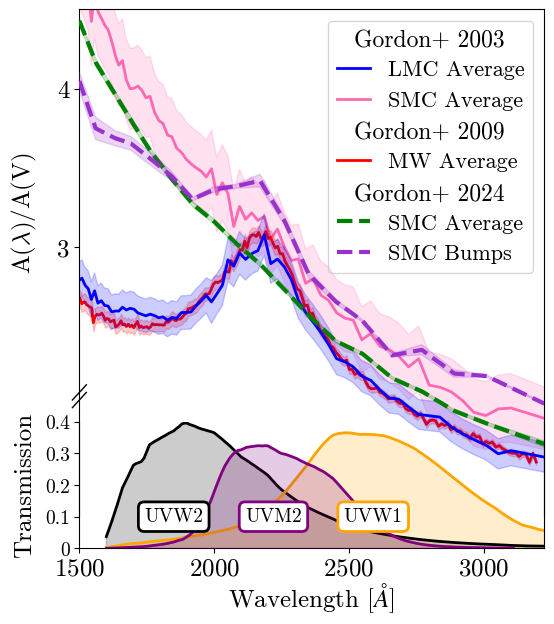

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import astropy.units as u
from matplotlib.patches import Rectangle
from matplotlib import rcParams

plt.style.use('/home/bethany/Projects/0_PublishedCode/SUMS_UVPhotometricCatalog/sums.mplstyle')
rcParams["mathtext.fontset"] = 'cm'
dir = '/home/bethany/Projects/0_Data/4_MagellanicClouds/Extinction/'

# Plot Parameters
plt.rcParams['ytick.labelsize'] = 18  
plt.rcParams['xtick.labelsize'] = 18



# Interpolate extinction curve 
def get_interpolated_gordon_function(gordon_file):
    # x [um^-1], A(lambda)/A(V), unc # unc = uncertainty
    gordon = pd.read_csv(gordon_file,skiprows=7,delimiter='\s+',names=['wavelength','extinction','error'])
    wav = (np.array(1 / gordon["wavelength"]) * u.micron).to(u.Angstrom)
    ext = gordon["extinction"]
    err = gordon["error"]
    interp_wav = np.arange(1500, 10000, 0.1)
    func = interpolate.interp1d(wav.value, ext)
    interp_ext = func(interp_wav)
    func_err = interpolate.interp1d(wav.value, err)
    interp_err = func_err(interp_wav)
    # Save all as df
    df = pd.DataFrame({"wavelength": interp_wav, "extinction": interp_ext, "error": interp_err})
    return df
def get_interpolated_gordon_function2(gordon_file,Rv =2.05440):
    # x [um^-1], E(lambda-V)/E(B-V), unc
    gordon = pd.read_csv(gordon_file,skiprows=7,delimiter='\s+',names=['wavelength','extinction','error'])
    wav = (np.array(1 / gordon["wavelength"]) * u.micron).to(u.Angstrom)
    # Convert to A(lambda)/A(V)
    ext = (gordon["extinction"]/Rv) + 1
    err = gordon["error"]
    interp_wav = np.arange(1500, 10000, 0.1)
    func = interpolate.interp1d(wav.value, ext)
    interp_ext = func(interp_wav)
    func_err = interpolate.interp1d(wav.value, err)
    interp_err = func_err(interp_wav)
    # Save all as df
    df = pd.DataFrame({"wavelength": interp_wav, "extinction": interp_ext, "error": interp_err})
    return df
def get_interpolated_pei_function(pei_file):
    pei = pd.read_csv(pei_file)
    pei['Wavelength'] = (1/pei['Wavelength'].to_numpy()* u.micron).to(u.Angstrom).value
    pei_wv = np.arange(1500, 10000, 0.1)
    func = interpolate.interp1d(pei['Wavelength'] , pei['Extinction'] )
    pei_ext = func(pei_wv)
    Rv = 2.93
    pei_ext = (pei_ext/Rv) + 1
    return pei_wv, pei_ext

# Extinction Curve Data - SMC AVG
pei_wv, pei_ext = get_interpolated_pei_function(dir+'ExtinctionCurve/Pei1992.csv')
pei_wv_lmc, pei_ext_lmc = get_interpolated_pei_function(dir+'ExtinctionCurve/Pei1992_LMC.csv')

# Extinction Curve Data - LMC AVG
ext_curve_lmc = get_interpolated_gordon_function(dir+'ExtinctionCurve/lmc_avg_ext.dat')

# Extinction Curve Data - LMC SuperShell 
ext_curve_lmc_ss = get_interpolated_gordon_function(dir+'ExtinctionCurve/lmc2_supershell_avg.dat') 

# Extinction Curve Data - SMC AVG - Gordon 2003
ext_curve_smc = get_interpolated_gordon_function(dir+'ExtinctionCurve/smc_bar_avg.dat')

# Extinction Curve Data - SMC Source in the Wings
ext_curve_smc_azv = get_interpolated_gordon_function2(dir+'ExtinctionCurve/azv456_azv70_ext.dat')

# Extinction Curve Data - SMC Bumps
ext_curve_smc_bumps = pd.read_csv(dir+'ExtinctionCurve/SMC_Bumps.csv')

# Extinction Curve Data - SMC AVG New - Gordon 2024
ext_curve_smc_avg = pd.read_csv(dir+'ExtinctionCurve/SMC_Avg.csv')

# UV Filters 
w2 = pd.read_csv(dir+'Filters/Swift_UVOT.UVW2_trn.dat',delimiter="\s+",names=['wavelength','transmission'])
w1 = pd.read_csv(dir+'Filters/Swift_UVOT.UVW1_trn.dat',delimiter="\s+",names=['wavelength','transmission'])
m2 = pd.read_csv(dir+'Filters/Swift_UVOT.UVM2_trn.dat',delimiter="\s+",names=['wavelength','transmission'])


# Plotting
f = plt.figure(constrained_layout=False, figsize=(6,7))
hspace = -.3
gs1 = f.add_gridspec(nrows=2, ncols=1, hspace=hspace, wspace=0.1, height_ratios=[1,0.25])
ax = f.add_subplot(gs1[0])
bx = f.add_subplot(gs1[1])

lw = 2
colors = ['blue','red','hotpink','green','darkorchid']

# LMC AVG
ax.plot(ext_curve_lmc['wavelength'],ext_curve_lmc['extinction'],label='LMC Average',color=colors[0],lw=lw)
ax.fill_between(ext_curve_lmc['wavelength'],ext_curve_lmc['extinction']-ext_curve_lmc['error'],ext_curve_lmc['extinction']+ext_curve_lmc['error'],color=colors[0],alpha=0.2)

# SMC AVG OLD 
ax.plot(ext_curve_smc['wavelength'],ext_curve_smc['extinction'],label='SMC Average',color=colors[2],zorder=0)
ax.fill_between(ext_curve_smc['wavelength'],ext_curve_smc['extinction']-ext_curve_smc['error'],ext_curve_smc['extinction']+ext_curve_smc['error'],color=colors[2],alpha=0.2,zorder=0)


# Milky Way Average
from dust_extinction.averages import (GCC09_MWAvg)
# Get Model
ext_model = GCC09_MWAvg()


# WITH ERROR BARS 
wv = (1/ext_model.obsdata_x_iue*u.micron).to(u.Angstrom).value
ind = np.where((wv > 1500) & (wv < 3500))
wv = wv[ind]
ext = ext_model.obsdata_axav_iue[ind]
err = ext_model.obsdata_axav_unc_iue[ind]
# remove two weird points 
ind = np.where((wv < 1600) & (ext > 2.7)) 
wv = np.delete(wv,ind)
ext = np.delete(ext,ind)
err = np.delete(err,ind)
ax.plot(wv,ext,label='MW Average',color='r',lw=lw,zorder=0,ls='-')
ax.fill_between(wv,ext-err,ext+err,color='r',alpha=0.2,zorder=0)

# SMC AVG NEW
ls = '--'
lw = lw + 1
ax.plot(ext_curve_smc_avg['wavelength'],ext_curve_smc_avg['extinction'],label='SMC Average',color=colors[3],lw=lw,zorder=10,ls=ls)
ax.fill_between(ext_curve_smc_avg['wavelength'],ext_curve_smc_avg['extinction']-ext_curve_smc_avg['error'],ext_curve_smc_avg['extinction']+ext_curve_smc_avg['error'],color=colors[3],alpha=0.2,zorder=10)

# SMC Bumps
ax.plot(ext_curve_smc_bumps['wavelength'],ext_curve_smc_bumps['extinction'],label='SMC Bumps',color=colors[4],lw=lw,zorder=10,ls=ls)
ax.fill_between(ext_curve_smc_bumps['wavelength'],ext_curve_smc_bumps['extinction']-ext_curve_smc_bumps['error'],ext_curve_smc_bumps['extinction']+ext_curve_smc_bumps['error'],color=colors[4],alpha=0.2,zorder=10)

# SMC Pei92
#ax.plot(pei_wv,pei_ext,label='SMC Pei+92',color='r',ls='--',lw=lw)

bx.plot(w2['wavelength'],w2['transmission'],label='Swift UVOT W2',color='black')
bx.plot(w1['wavelength'],w1['transmission'],label='Swift UVOT W1',color='orange')
bx.plot(m2['wavelength'],m2['transmission'],label='Swift UVOT M2',color='purple')

# Fill between transmission and bottom of plot 
bx.fill_between(w2['wavelength'],w2['transmission'],color='black',alpha=0.2)
bx.fill_between(w1['wavelength'],w1['transmission'],color='orange',alpha=0.2)
bx.fill_between(m2['wavelength'],m2['transmission'],color='purple',alpha=0.2,zorder=10)

# Make box to label UV filters
y = .10
bx.text(1850, y, 'UVW2', ha="center", va="center", size=14, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=2),zorder=10)
bx.text(2220, y, 'UVM2', ha="center", va="center", size=14, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="purple", lw=2),zorder=10)
bx.text(2590, y, 'UVW1', ha="center", va="center", size=14, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="orange", lw=2),zorder=10)

# Add two diagonal lines over the axes 
d = .015
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False,lw=1)
y = 0.23
ax.plot((-d, +d), (y-d, y+d), **kwargs)
ax.plot((-d, +d), (y-d+d, y+d+d), **kwargs)

##########
# LEGEND #
##########
# DUMMY POINT
ax.scatter(-100,-1000,label=" ",c='white',s=10)
fs = 16
handles, labels = ax.get_legend_handles_labels()
new_handles = [handles[-1],handles[0],handles[1],handles[-1],handles[2],handles[-1],handles[3],handles[4]]
new_labels = [labels[-1],labels[0],labels[1],labels[-1],labels[2],labels[-1],labels[3],labels[4]]
leg = ax.legend(new_handles,new_labels,fontsize=fs,facecolor='none',handlelength=1.5,loc='upper right')
# If we add the supershell back 2700 + 10 and  [4.3-0.03,3.605-0.11,3.08-0.17]
n = -180
ax.text(2700+n,4.27,"Gordon+ 2003",fontsize=fs+1,zorder=100)
ax.text(2700+n,3.69,"Gordon+ 2009",zorder=100,fontsize=fs+1)
ax.text(2700+n,3.3,"Gordon+ 2024",zorder=100,fontsize=fs+1)
# Uncomment to underline the text 
# ysep = 0.04
# xstop = 630
# xstart = 70
# ax.plot([2700+n-xstart,2700+n+xstop],[4.27-ysep,4.27-ysep],color='black',lw=1)
# ax.plot([2700+n-xstart,2700+n+xstop],[3.69-ysep,3.69-ysep],color='black',lw=1)
# ax.plot([2700+n-xstart,2700+n+xstop],[3.3-ysep,3.3-ysep],color='black',lw=1)


# Set limits and labels 
[axx.set_xlim(1500,3225) for axx in [ax,bx]]
ax.set_ylabel('A($\lambda$)/A(V)',labelpad=13,y=.6,fontsize=18)
bx.set_ylabel('Transmission',fontsize=18,y=.5,labelpad=6)
bx.set_xlabel('Wavelength [$\\AA$]',fontsize=18)
bx.patch.set_alpha(0)
# Sex yticks top plot 
ax.set_ylim(1.3,4.5)
ax.set_yticks([3,4])
ax.set_yticklabels(['3','4'])
# Sex yticks bottom plot 
bx.set_ylim(0,0.4)
bx.set_yticks([0,0.1,0.2,0.3,0.4])
bx.set_yticklabels(['0','0.1','0.2','0.3','0.4'],fontsize=14)
# Remove spine
ax.spines['bottom'].set_visible(False)
bx.spines['top'].set_visible(False)
# Remove x axis from top plot
ax.xaxis.set_visible(False)



# Save 
plt.savefig('ExtinctionCurveWithRef.png',bbox_inches='tight',dpi=300)